<a href="https://colab.research.google.com/github/ezorigo/DS-Unit-2-Kaggle-Challenge/blob/master/module1/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
import pandas_profiling

pandas_profiling.ProfileReport(train)

In [78]:
train, val = train_test_split(train,
                              test_size=0.25,
                              stratify=train['status_group'], 
                              random_state=0)

train.shape, val.shape

((44550, 41), (14850, 41))

In [4]:
import plotly.express as px

px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

In [5]:
train[['longitude', 'latitude']].describe()

longitude      latitude
count  44550.000000  4.455000e+04
mean      34.087035 -5.696212e+00
std        6.532098  2.938967e+00
min        0.000000 -1.164944e+01
25%       33.090521 -8.520562e+00
50%       34.906774 -5.012737e+00
75%       37.171625 -3.326168e+00
max       40.344301 -2.000000e-08

In [0]:
# data wrangling

import numpy as np

def wrangle(x):
  """wrangle trian, val, and test sets in the same way"""
  
#   make copy
  x = x.copy()
#   replace outliers with 0
  x['latitude'] = x['latitude'].replace(-2e-08, 0)
#   replace 0's with np.nan
  cols_with_zeros = ['longitude', 'latitude', 'amount_tsh', 'construction_year', 'gps_height', 'population']
  for col in cols_with_zeros:
    x[col] = x[col].replace(0, np.nan)
#   drop duplicate
  x = x.drop(columns='quantity_group')
#   drop num_private too many null values
#   x = x.drop(columns='num_private')
#   make new feature
  x['date_recorded'] = pd.to_datetime(x['date_recorded'], infer_datetime_format=True)
  x['construction_year'] = pd.to_datetime(x['construction_year'], infer_datetime_format=True)
  x['time_from_construction'] = (x['date_recorded'] - x['construction_year']).astype('timedelta64[h]')
  
  x = x.drop(columns=['date_recorded', 'construction_year'])
#   Reduce cardinality 
  high_cardinality = ['wpt_name', 'subvillage', 'scheme_name', 'ward', 'installer', 'funder', 'lga']
  for col in high_cardinality:
    top = x[col].value_counts(ascending=False)[:49].index
    x.loc[~x[col].isin(top), col] = 'other'
  
  return x

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [31]:
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

In [32]:
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [80]:
# select features

target = 'status_group'

train_features = train.drop(columns=[target, 'id'])
numeric_features = train_features.select_dtypes(include='number').columns.to_list()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.to_list()

features = numeric_features + categorical_features

print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'time_from_construction', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# features matrix and target vector

x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]

In [46]:
# scikit-learn pipelines

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

pipeline.fit(x_train, y_train)

print('Train Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))

y_pred = pipeline.predict(x_test)

Train Accuracy 0.7679910213243547
Validation Accuracy 0.7569023569023569


In [0]:
from sklearn.svm import LinearSVC

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LinearSVC(random_state=0,
              dual=False
             )
)

pipeline.fit(x_train, y_train)

print('Train Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))

y_pred = pipeline.predict(x_test)

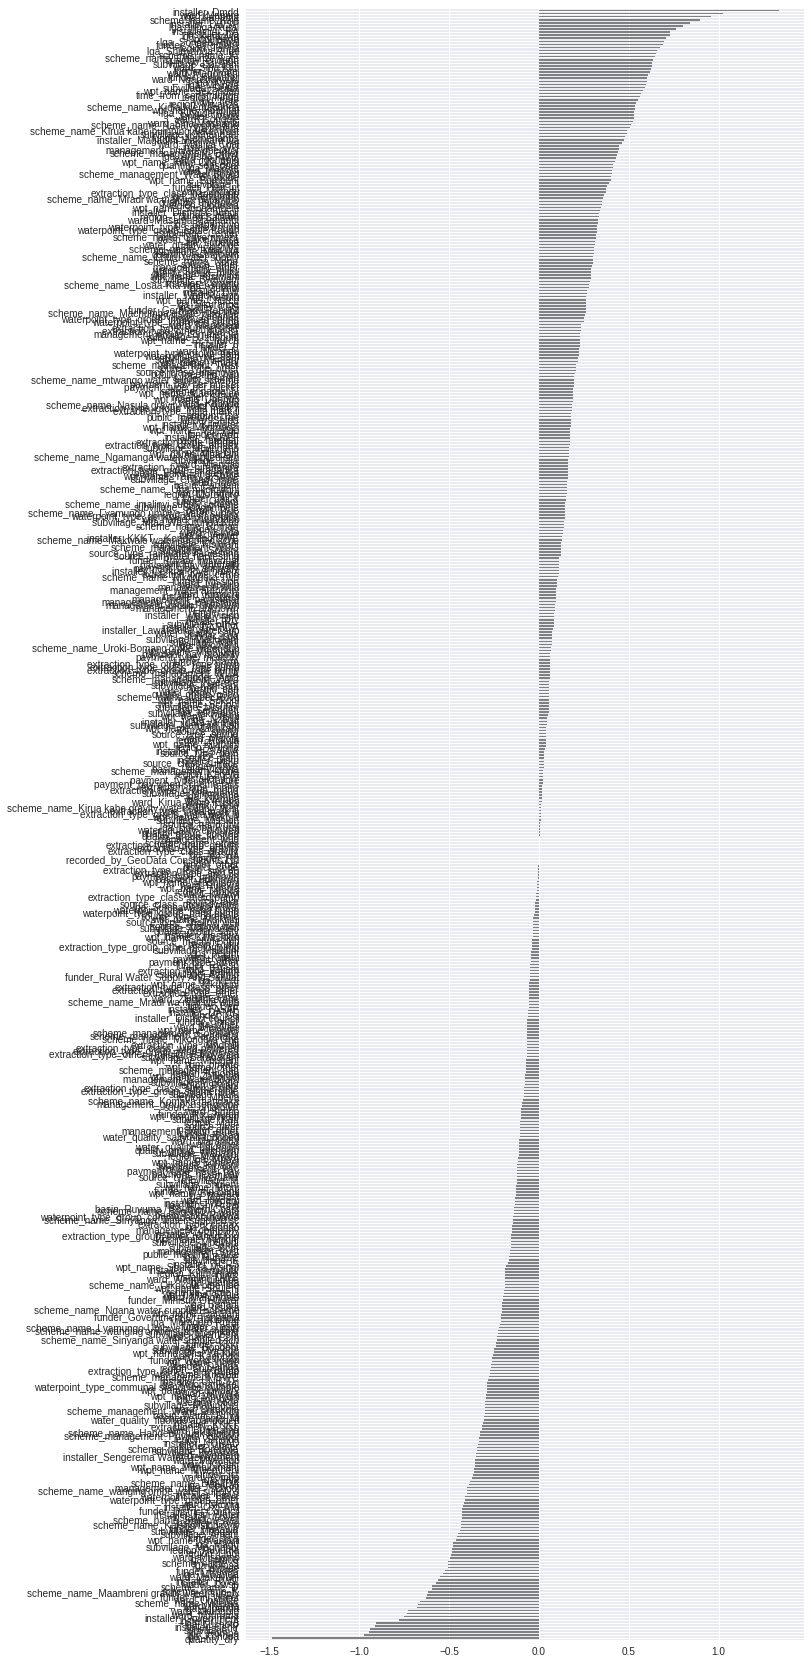

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn')

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(x_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [47]:
# scikit-learn pipeline using DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=0)
)

pipeline.fit(x_train, y_train)

print('Train Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))

y_pred = pipeline.predict(x_test)

Train Accuracy 0.9986980920314253
Validation Accuracy 0.7601346801346801


In [62]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(criterion='gini',
                           splitter='best',
                           max_depth=24, 
                           random_state=0)
)

pipeline.fit(x_train, y_train)

print('Train Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))

y_pred = pipeline.predict(x_test)

Train Accuracy 0.9041750841750842
Validation Accuracy 0.7775757575757576


In [132]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1,
                           n_estimators=100,
                           min_samples_leaf=3,
                           max_depth=30,
                           random_state=0
    )
)

pipeline.fit(x_train, y_train)

print('Train Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))

y_pred = pipeline.predict(x_test)

Train Accuracy 0.8342760942760943
Validation Accuracy 0.7960942760942761


In [22]:
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(x_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

KeyError: ignored

### submission


In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-05.csv', index=False)

In [64]:
!head submission-05.csv

id,status_group
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,non functional
28965,non functional
36301,non functional


In [0]:
if in_colab:
    from google.colab import files
    # Just try again if you get this error:
    # TypeError: Failed to fetch
    # https://github.com/googlecolab/colabtools/issues/337
    files.download('submission-05.csv')